## Setup
---

### Imports
---

Importing the necessary libraries to work with the data as well as algorithms

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Processing
---

Here we are importing the data we took from Tracker. We took a video of a toy
car being launched from a toy car launcher (video included in zip) which we then
tracked using tracker. Tracker can export this data as a txt file, which we open
up below.

In [174]:
# Import Data
df = pd.read_csv('car_launch_data_5.txt', header=1, delim_whitespace=True)


# Clean data
# Recenter y data; Translate Y data, shift lowest y to 0
m = min(df['y'])
df['y'] = df['y'].apply(lambda x: x-m)

# Make t start at 0
# t_offset = min(df['x'])
# df['t'] = df['t'].apply(lambda x: x-t_offset)

print(df)

        t      x      y
0   0.000  0.132  1.057
1   0.033  0.223  1.140
2   0.067  0.317  1.214
3   0.100  0.411  1.278
4   0.133  0.480  1.319
5   0.167  0.585  1.369
6   0.200  0.678  1.403
7   0.233  0.770  1.425
8   0.267  0.872  1.437
9   0.300  0.938  1.440
10  0.333  1.027  1.432
11  0.367  1.115  1.414
12  0.400  1.201  1.387
13  0.433  1.290  1.343
14  0.467  1.376  1.296
15  0.500  1.461  1.238
16  0.533  1.564  1.152
17  0.567  1.634  1.085
18  0.600  1.715  0.998
19  0.633  1.803  0.891
20  0.667  1.881  0.789
21  0.700  1.957  0.677
22  0.733  2.033  0.557
23  0.767  2.108  0.430
24  0.800  2.181  0.294
25  0.833  2.253  0.150
26  0.867  2.323  0.000


### Initial Plots
---

These initial plots will help give us an idea of the exact trajectory of the car
through the air. The plots are surprisingly smooth, which is a good sign that we
have some decent data.

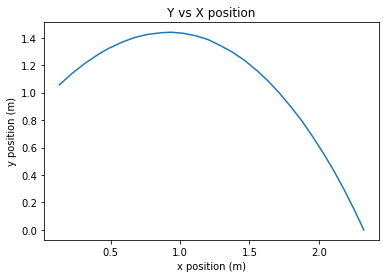

In [175]:
# Initial visualization of the data
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.title("Y vs X position")
plt.plot(df['x'], df['y'])

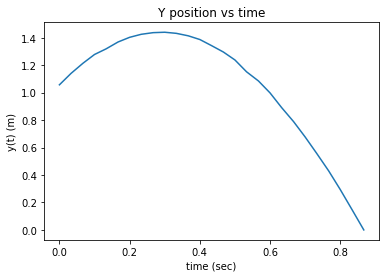

In [176]:
plt.xlabel("time (sec)")
plt.ylabel("y(t) (m)")
plt.title("Y position vs time")
plt.plot(df['t'], df['y'])

Text(0.5, 1.0, 'X position vs time')

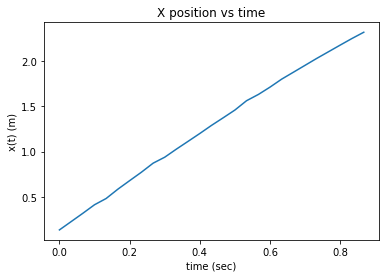

In [177]:
plt.plot(df['t'], df['x'])
plt.xlabel("time (sec)")
plt.ylabel("x(t) (m)")
plt.title("X position vs time")

### Simulation Helpers
---

These are some constants that we will always be using throughout the entire
project, thus we've chosen to make them global for ease of access.

In [178]:
# Constants
g   = 9.8               # gravity (m/s^2)

t0  = 0                 # initial Time (s) 
dt  = .033              # time resolution

tf  = 0.867             # total time to simulate
nsteps = int(tf/dt) + 1 # number of time steps

# data converted to matrix forms
x_data = df['x'].values
y_data = df['y'].values
t_data = df['t'].values

# Calculate inital conditions based on two given (early) coordinate points
# inputs:
#   coord1: a tuple containing time, x and y coordinates (early time)
#   coord2: another tuple of the same type (later time)
# outputs:
#   a tuple containing x and y positions and velocities
def initial_conditions(coord1, coord2):
    t    = coord2[0] - coord1[0]
    x    = coord2[1] - coord1[1]
    y    = coord2[2] - coord1[2]

    return x/t, y/t, coord1[1], coord1[2]


What follows is a helper program that will quickly do plots for us

In [179]:
# a helpful function for making quick plots (notably not a lot of
# customizability, just nice and easy plots in a single function call)
# inputs:
#   pars: the parameters used to create the plots (eg, time and x-coord)
#   ftitle: figure title
#   numerous other optional arguments for customizability
def make_plot(pars, ftitle, x_err=[], y_err=[], flabel=[], faxis=['']*2, fsize=[6, 4]):
    # this will make sure we don't align labels incorrectly
    if flabel == []:
        flabel = ['']*len(pars)
    

    # create the fig
    fig = plt.figure(figsize=(fsize[0], fsize[1]))

    # loop through to plot all the given lines
    for i in range(len(pars)):
        plt.plot(pars[i][0], pars[i][1], label=flabel[i])

    # handles what to do if errors given
    if not (x_err == []):
        plt.errorbar(pars[0][0], pars[0][1], xerr=x_err,  color='r', linewidth=.5)
    if not (y_err == []):
        plt.errorbar(pars[0][0], pars[0][1], yerr=y_err,  color='r', linewidth=.5)

    # other parameters for the plot
    plt.title(ftitle)
    plt.xlabel(faxis[0])
    plt.ylabel(faxis[1])
    plt.ylim([0, 3])
    plt.legend()

### Error
---

A helpful function for later

In [180]:
# the error function here just calculates the point per point percentage error
# input:
#   actual: the actual data
#   expected: the expected values (from calculations)
# output:
#   the error in a list for plotting
def err(actual, expected):
    if not len(actual) == len(expected):
        return "number of data points do not match"
    else:
        return [round(abs(actual[i] - expected[i]), 5) for i in range(len(actual)) ]

## Euler Method (Algorithm 1)
---

Now we arrive at the first of our algorithms. We are gonna be executing the
Euler Method here. The goal is to take a discretized time step approach to
standard kinematic equations in 2D. <br>

So for any given variable of interest, we can time evolve it in the following
way:

$$ y(t+h) = y(t) + hf(t,y) $$

Where $h$ is the timestep of our system (dt in the code below). We also defined
$f(t,y)$ to be $\frac{dy}{dt}$, or the velocity when discussing the position
components. <br>

Implementing all of this is shown below making use of the equations we wrote in
the previous section.

In [181]:
# Euler method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

vx = np.zeros([nsteps])
vy = np.zeros([nsteps])
y  = np.zeros([nsteps])
x  = np.zeros([nsteps])

# Initial Conditions
vx0, vy0, x0, y0          = initial_conditions(df.loc[0], df.loc[1])
y[0], x[0], vx[0], vy[0]  = y0, x0, vx0, vy0

# a debug printout
print("X vel:", vx0, "m/s")
print("Y vel:", vy0, "m/s")
print("X pos:", x0,  "m")
print("Y pos:", y0,  "m")

## time evolving
for i in range(0, nsteps-1):
    # evolve the y components
    y[i+1]  = y[i] + dt * vy[i]
    vy[i+1] = vy[i] - dt * g

    # evolve the x components
    x[i+1]  = x[i] + dt * vx[i]
    vx[i+1] = vx[i]                 # vx is constant without air resitance



X vel: 2.7575757575757573 m/s
Y vel: 2.515151515151514 m/s
X pos: 0.132 m
Y pos: 1.057 m


### Data vs Euler 
---

Now that we have created a list of points for the expected outcome (ie the Euler
method simulation), we can compare these values to the gathered data. We expect
to see increasing discrepancies due to the influence of air resistance, which is
not accounted for in this report as the geometry and induced rotation on the car
is too complex to meaninfully simulate in the scope of this project.

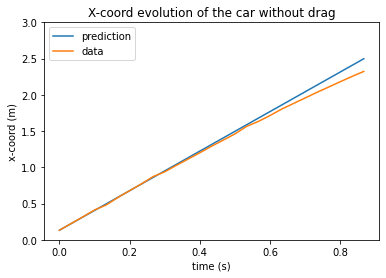

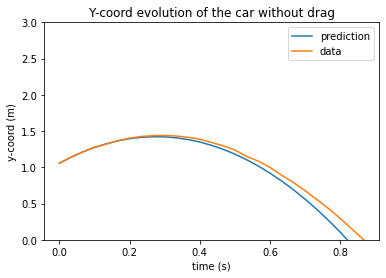

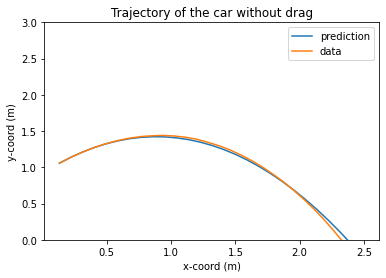

In [182]:
make_plot([[t, x], [t_data, x_data]],
          "X-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "x-coord (m)"])

make_plot([[t, y], [t_data, y_data]],
          "Y-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "y-coord (m)"])

make_plot([[x, y], [x_data, y_data]],
          "Trajectory of the car without drag",
          flabel=["prediction", "data"],
          faxis=["x-coord (m)", "y-coord (m)"])

We can see it behaves exactly as expected for an object experiencing air
resistance. The y coordinate changes slower towards the end, and the x
coordinate velocity also falls off towards the end of the video. We can also see
the Euler method predicts the object will land farther than it actually does.
<br>

All in all, this is a good sign, and expected in the scope of the project.

### Error Plots - Euler vs Continuous Distribution
---

Now that we have conducted a comparison of the data to Euler Method predictions,
we can compare the Euler method prediction to that of the continuous plot formed
by the standard equations of motion. In this way, we can quantify the error
between the discretization method offered by Euler's Algorithm.

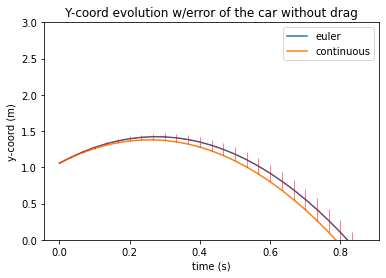

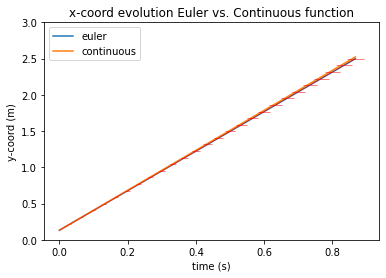

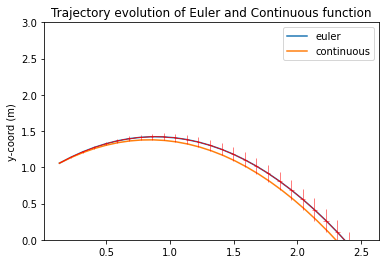

In [183]:
# we calculate the paths directly
b = y0 + vy0 * t - (1/2) * g * t**2
c = x0 + vx0 * t

x_err = err(x, c)
y_err = err(y, b)

# plots
make_plot([[t, y], [t, b]],
          "Y-coord evolution w/error of the car without drag",
          flabel=["euler", "continuous"],
          faxis=["time (s)", "y-coord (m)"],
          y_err = y_err)

make_plot([[t, x], [t, c]],
          "x-coord evolution Euler vs. Continuous function",
          flabel=["euler", "continuous"],
          faxis=["time (s)", "y-coord (m)"],
          x_err = x_err)

make_plot([[x, y], [c, b]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["euler", "continuous"],
          faxis=["", "y-coord (m)"],
          x_err = x_err,
          y_err = y_err)


Quickly, we can just plot the error for the trajectory to see how it changes
over time.

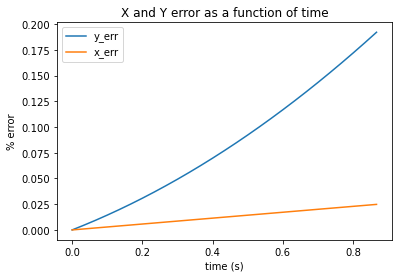

In [197]:
# plotted regularly bc of the hard ylim boundaries coded into the make_plot
# function (one of it's downfalls)
plt.plot(t, y_err, label="y_err")
plt.plot(t, x_err, label="x_err")
plt.title("X and Y error as a function of time")
plt.xlabel("time (s)")
plt.ylabel("% error")
plt.legend()

So clearly, the error (particularly in the y) grows to be quite large (nearly 20
percent) by the end of the time period we are looking at.

We will see if other methods can do better

## Bashforth-Adams (Algorithm 2)
---

The bashforth-adams algorithm is apparently an improvement on the Euler
algorithm so we will make an attempt at comparing them here

For a given position component, we have: <br>
$$ y_{n+1} = y_n + \frac{3}{2} \delta t f\left(t_n,y_n\right) - \frac{1}{2} \delta t f\left(t_{n-1},y_{n-1}\right)$$

Here the function $f$ is the derivative of the position component in question,
thus we will be initializing it as the velocity. The general idea here is not to
take the exact next time step evolution of the system, but an average of a few
of a couple of the slopes.

The initial setup is fairly straightforward, with one notable difference. We
have to consider two timesteps at any given moment. One way to do this is to use
the Euler method to get the first values of the system, however, for plotting
data, we can actually just pull from the data to get these values, and thisis
exactly what we do.

In [198]:
# Bashforth-Adams method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

# BA Initial Conditions
vy_ba = np.zeros([nsteps])
vx_ba = np.zeros([nsteps])
y_ba  = np.zeros([nsteps])
x_ba  = np.zeros([nsteps])

# Initial Conditions
vx0, vy0, x0, y0    = initial_conditions(df.loc[0], df.loc[1])
vx1, vy1, x1, y1    = initial_conditions(df.loc[1], df.loc[2])
y_ba[0], x_ba[0], vx_ba[0], vy_ba[0]  = y0, x0, vx0, vy0
y_ba[1], x_ba[1], vx_ba[1], vy_ba[1]  = y1, x1, vx1, vy1

In [201]:
# Time evolving
for i in range(0, nsteps-2):
    y_ba[i+2]  = y_ba[i+1] + dt * (3/2*vy_ba[i+1] - 1/2*vy_ba[i])
    vy_ba[i+2] = vy_ba[i+1] - dt * g

    x_ba[i+2]  = x_ba[i+1] + dt * (3/2*vx_ba[i+1] - 1/2*vx_ba[i])
    vx_ba[i+2] = vx_ba[i]


### Data vs BA 
---

Here we are plotting the Data against Bashforth-Adams Method, similarly to how
we plotted against Euler in the previous section.

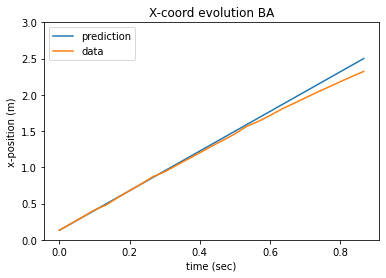

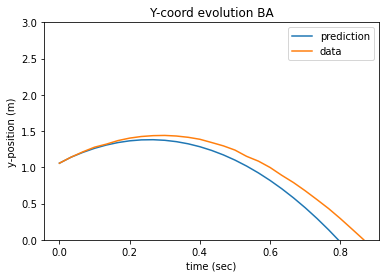

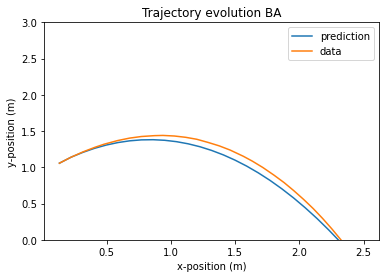

In [202]:
make_plot([[t, x_ba], [t_data, x_data]],       # data plotting (pars)
          "X-coord evolution BA",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"])
        
make_plot([[t, y_ba], [t_data, y_data]],       # data plotting (pars)
          "Y-coord evolution BA",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "y-position (m)"])

make_plot([[x_ba, y_ba], [x_data, y_data]],       # data plotting (pars)
          "Trajectory evolution BA",
          flabel=["prediction", "data"],
          faxis=["x-position (m)", "y-position (m)"])

The results of this are generally interesting. Just from looking at it, we can
see the effects of air resistance seem to be even more pronounced, likely due to
Bashforth-Adams being closer to the continuous plots, thus putting more distance
between it and the data we collected.

### Error Plots - BA vs Continuous Plot
---

Here we put a few different plots down to compare the data, Euler, and BA

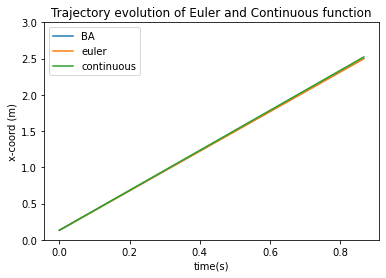

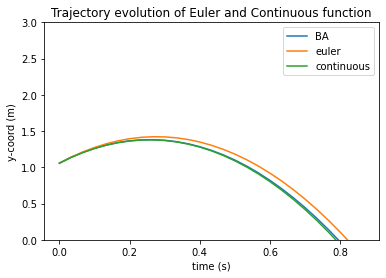

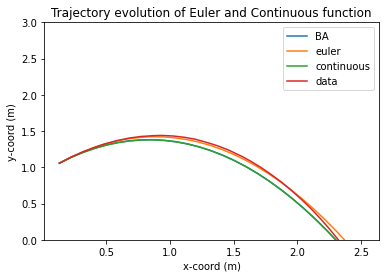

In [212]:
# errors
x_err_ba = err(x_ba, c)
y_err_ba = err(y_ba, b)

# plots
make_plot([[t, x_ba], [t, x], [t, c]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous" ],
          faxis=["time(s)", "x-coord (m)"])

make_plot([[t, y_ba], [t, y], [t, b]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous" ],
          faxis=["time (s)", "y-coord (m)"])
          
make_plot([[x_ba, y_ba], [x, y], [c, b], [x_data, y_data]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous", "data" ],
          faxis=["x-coord (m)", "y-coord (m)"])

We can see that BA is in fact closer to the continuous function that we are
trying to emulate here, while being farther from the data. I haven't included
error bars here, as I feel a more clear demonstration of the error can be seen
in the plot below (I'd rather not clutter the plot any more than it already is).

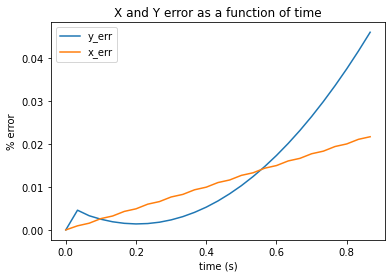

In [213]:
# plotted regularly bc of the hard ylim boundaries coded into the make_plot
# function (one of it's downfalls)
plt.plot(t, y_err_ba, label="y_err")
plt.plot(t, x_err_ba, label="x_err")
plt.title("X and Y error as a function of time")
plt.xlabel("time (s)")
plt.ylabel("% error")
plt.legend()

We can see the error is, in fact, an order of magnitude better compared to the
Euler algorithm. The unnatural immediate increase in error seen in the y_error
line are almost certainly due to our decision to use the data to get the first
two points for the BA time evolution. This would likely be a much smoother
distribution if we had used Euler's to determine the second point.

## Runge-Kutta (Algorithm 3)
---

NOTE FROM THE FUTURE: <br>
What follows is a currently broken implementation of Runge-Kutta fourth order
(RK4). We attempted this, but were unable to make it work in time due to some
confusion about how the equations are meant to be setup. Maybe in the future we
will come back to this and fix it, but for now we figured it would be nice to
leave it. As such, it's rather poorly documented.


---

Now we hope to do the same analysis, but instead on the Runge-Kutta algorithm

The Runge-Kutta algorithm is described by the following set of equations <br>
\begin{align*}
y_{n+1} &= y_n+\frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)h \\
k_1 &= f(t_n,y_n) \\
k_2 &= f(t_n + \frac{h}{2}, y_n+\frac{h}{2}k_1)  \\
k_3 &= f(t_n +\frac{h}{2}, y_n + \frac{h}{2}k_3) \\
k_4 &= f(t_n + h, y_n + hk_3) \\
h   &= \text{step size}
\end{align*}
For this, I think it may be best to write a small function for the velocity involved, as it should simplify our notation throughout this process

In [ ]:
# Euler method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

vx = np.zeros([nsteps])
vy = np.zeros([nsteps])
y  = np.zeros([nsteps])
x  = np.zeros([nsteps])

# Initial Conditions
vx0, vy0, x0, y0          = initial_conditions(df.loc[0], df.loc[1], nsteps)
y[0], x[0], vx[0], vy[0]  = y0, x0, vx0, vy0

In [ ]:
def fy(v):
    return v *dt
def fvy(v):
    return v - g * dt

In [ ]:
for i in range(0, nsteps-1):
    ky1  = fy(vy[i])
    ky2  = fy(vy[i] + ky1 * dt/2)
    ky3  = fy(vy[i] + ky2 * dt/2)
    ky4  = fy(vy[i] + ky3 * dt)

    kvy1 = fvy(vy[i])
    kvy2 = fvy(vy[i] + kvy1 * dt/2)
    kvy3 = fvy(vy[i] + kvy2 * dt/2)
    kvy4 = fvy(vy[i] + kvy3 * dt)

    y[i + 1]  = y[i]  + (ky1  + 2 * ky2   + 2 * ky3  + ky4)  * dt/6
    vy[i + 1] = vy[i] + (kvy1 + 2 * kvy2  + 2 * kvy3 + kvy4) * dt/6


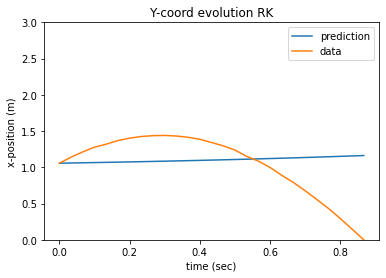

In [ ]:
make_plot([[t, y], [t_data, y_data]],       # data plotting (pars)
          "Y-coord evolution RK",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"])

In [ ]:
print(y)

[1.05700000e+00 1.14000000e+00 1.29532780e+00 1.59531120e+00
 2.18460580e+00 3.35252280e+00 5.67768460e+00 1.03173360e+01
 1.95859666e+01 3.81125556e+01 7.51550614e+01 1.49229401e+02
 2.97367407e+02 5.93632748e+02 1.18615276e+03 2.37118211e+03
 4.74123013e+03 9.48131550e+03 1.89614756e+04 3.79217851e+04
 7.58423933e+04 1.51683599e+05 3.03366000e+05 6.06730792e+05
 1.21346036e+06 2.42691950e+06 4.85383776e+06]


make_plot([[t, x_ba], [t_data, x_data]],       # data plotting (pars)
          "X-coord evolution BA",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"])

# Energy calculations
---

What follows is a brief look at the energy of our system (from data) and a look
at the energy in an algorithmic approach (such as BA or Euler).

We know that Kinetic Energy (T) take the form <br>

$$ T = \frac{1}{2}mv^2 $$

Where here the square of the velocity component will be <br>

$$ v = \sqrt{v_x^2 + v_y^2} \longrightarrow v^2 = v_x^2 + v_y^2 $$

We can divide out the mass to get units of $J / kg$ which will simplify things.
Thus we have <br>

$$ T/m = T_m = \frac{1}{2}\left(v_x^2 + v_y^2\right) $$

Now we can go ahead and try to calculate the kinetic energy for our toy car on
it's path.

We also would want to see the potential energy against the kinetic which we have
just calculated. Similarly to T, we get <br>

$$ U = mgh \longrightarrow U_m = gh $$



In [254]:
# x_data, y_data, t_data
vx_data = []
vy_data = []
tm      = []
um      = []
e       = []

for i in range(len(t_data) - 1):
    dt = t_data[i+1] - t_data[i]
    vx = (x_data[i+1] - x_data[i])/dt
    vy = (y_data[i+1] - y_data[i])/dt

    vx_data.append(vx)
    vy_data.append(vy)

    
    um.append(y_data[i] * g)
    # if i > 1:
    tm.append(1/2 * (vx**2 + vy**2))

    e.append(um[i] + tm[i])
    
## debug helper
# print(tm)
# print(um)
print(e)

[17.323705601469236, 17.362311418685124, 17.834757392102848, 15.482159412304865, 18.77611349480969, 17.918036547291102, 17.85775629017447, 18.52728373702422, 16.08673223140496, 17.778207529843886, 17.52321937716264, 17.58768668503214, 18.118311662075307, 17.315811764705863, 17.562599816345298, 20.399158494031212, 15.350586159169557, 17.120603305785124, 18.592613039485737, 15.863287889273348, 16.143586593204823, 15.898144536271783, 14.867769550173007, 15.152934802571153, 14.782026446281048, 13.321211072664333]


Now we can plot to see the relationship between the kinetic and potential
energy. We hope to see a sort of gold fish shape as the potential turns to
kinetic.

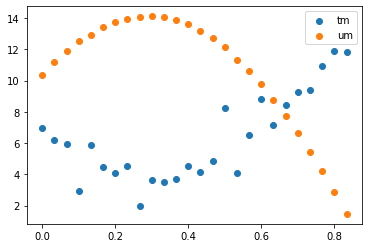

In [258]:
plt.scatter(t[:-1], tm, label='tm')
plt.scatter(t[:-1], um, label='um')
plt.legend()

Very nice! The kinetic is a bit erratic which makes sense considering how we
acquired the data. All in all, a good show.

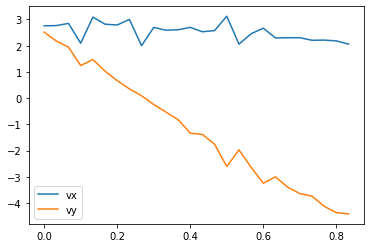

In [260]:
plt.plot(t[:-1], vx_data, label='vx')
plt.plot(t[:-1], vy_data, label='vy')
plt.legend()

Here we plot the velocities, just for the sake of seeing how they change, and
they do change how we expect. This is just one way to make sure we are
calculating the velocities correctly when doing the kinetic energy

# Conclusions
---

In brief conclusion, we showed the relative accuracies of the Euler Method
compared to the Bashforth-Adams method, and seen how both of them compare to
data. Alongside that we got to see how the air resistance experienced by the car
in motion changed the trajectory compared to simulations.